In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
MI_DF = pd.read_pickle(DATA_DIR / "mi" / "phonbank_mi_full_median_shuffled.pickle")

In [6]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,median_n_phones,shuffling
0,"[10.462783652449525, 9.983388971328182, 9.7520...","[0.0049862970087629875, 0.004861915778448901, ...","[9.581032058713163, 9.580828108367228, 9.58096...","[0.004776055346142387, 0.004775665750301762, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,310065,0,1574,full
1,"[5.740400393887644, 5.659412386387666, 5.62936...","[0.009623133671282348, 0.009617792466309692, 0...","[5.60940114322489, 5.609992145894537, 5.609532...","[0.009598316995692623, 0.009589218644341833, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,310065,0,1574,shuffled_within_words
2,"[10.41829005815009, 9.936921844638222, 9.69985...","[0.004978099712851141, 0.00484636226919765, 0....","[9.579728969514637, 9.581403782018807, 9.57992...","[0.004774484282599742, 0.004775984491959822, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,310065,0,1574,shuffled_between_words


In [7]:
MI_DF.shuffling.unique()

array(['full', 'shuffled_within_words', 'shuffled_between_words',
       'shuffled_within_utterance', 'no_repeats',
       'shuffled_between_utterance', 'shuffled_within_transcript'],
      dtype=object)

In [8]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [9]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    dist_mask = distances <= row.median_n_phones
    distances = distances[dist_mask]
    sig = sig[dist_mask]
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]

    print(row.age_cohort_low, row.age_cohort_high, best_fit_model, row.shuffling)

/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))


3 20 pow_exp full
3 20 pow_exp shuffled_within_words
3 20 pow_exp shuffled_between_words
3 20 pow_exp shuffled_within_utterance
3 20 pow_exp no_repeats
3 20 pow_exp shuffled_between_utterance
3 20 pow shuffled_within_transcript
2.5 3 pow_exp full
2.5 3 pow_exp shuffled_within_words
2.5 3 exp shuffled_between_words
2.5 3 pow_exp shuffled_within_utterance
2.5 3 pow_exp no_repeats
2.5 3 pow_exp shuffled_between_utterance
2.5 3 pow shuffled_within_transcript
2 2.5 pow_exp full
2 2.5 pow shuffled_within_words
2 2.5 exp shuffled_between_words
2 2.5 pow_exp shuffled_within_utterance
2 2.5 pow_exp no_repeats
2 2.5 pow_exp shuffled_between_utterance
2 2.5 exp shuffled_within_transcript
1.5 2 pow_exp full
1.5 2 pow_exp shuffled_within_words
1.5 2 exp shuffled_between_words
1.5 2 pow_exp shuffled_within_utterance
1.5 2 pow_exp no_repeats
1.5 2 pow_exp shuffled_between_utterance
1.5 2 pow shuffled_within_transcript
1 1.5 pow_exp full
1 1.5 pow_exp shuffled_within_words
1 1.5 pow_exp shuffled_betwe

In [10]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,median_n_phones,...,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[10.462783652449525, 9.983388971328182, 9.7520...","[0.0049862970087629875, 0.004861915778448901, ...","[9.581032058713163, 9.580828108367228, 9.58096...","[0.004776055346142387, 0.004775665750301762, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,310065,0,1574,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.803401,0.841454,0.840546,-5687.125636,-5998.032033,-5993.698165,pow_exp,"[-3.466673961285433e-06, -5.218923875438178e-0...",189.0
1,"[5.740400393887644, 5.659412386387666, 5.62936...","[0.009623133671282348, 0.009617792466309692, 0...","[5.60940114322489, 5.609992145894537, 5.609532...","[0.009598316995692623, 0.009589218644341833, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,310065,0,1574,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.744447,0.806274,0.804592,-3315.562404,-3589.895654,-3585.247737,pow_exp,"[-7.665690649704763e-06, -1.1500075645919643e-...",6.0
2,"[10.41829005815009, 9.936921844638222, 9.69985...","[0.004978099712851141, 0.00484636226919765, 0....","[9.579728969514637, 9.581403782018807, 9.57992...","[0.004774484282599742, 0.004775984491959822, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,310065,0,1574,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.857692,0.858956,0.850476,-3204.513272,-3208.395193,-3160.587539,pow_exp,"[-1.0032263994535291e-05, -1.5071595313980539e...",316.0


In [11]:
from matplotlib import gridspec

In [54]:
MI_DF_subset = MI_DF[MI_DF.shuffling == 'full']
len(MI_DF_subset)

6

### main decay

69 69
189 189
276 276
879 879
1150 1150
1574 1574


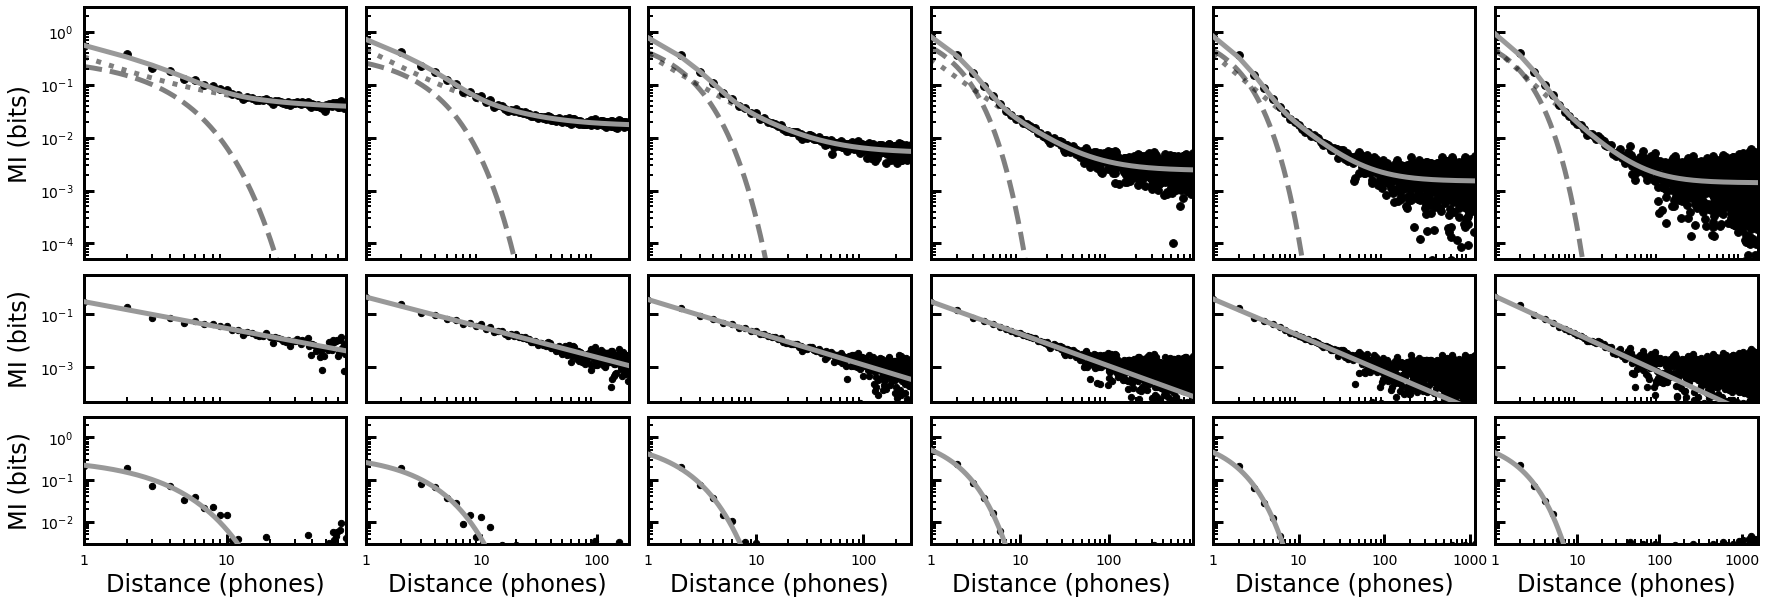

In [76]:
yoff=-.20
ncols = 4
zoom = 5
hr = [1, 0.5, 0.5, 0.5]
nrows = np.ceil(len(MI_DF_subset)/ncols).astype(int)
fig = plt.figure(figsize=(len(MI_DF_subset)*zoom,np.sum(hr)*zoom)) 
gs = gridspec.GridSpec(ncols=len(MI_DF_subset), nrows=4, height_ratios=hr) 

for axi, (idx, row) in enumerate(MI_DF_subset.sort_values(by=['age_cohort_low']).iterrows()):
    color = 'k'#LCOL_DICT[row.language]
    ax0 = plt.subplot(gs[0,axi])
    ax = ax0
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    
    dist_mask = distances <= row.median_n_phones
    distances = distances[dist_mask]
    sig = sig[dist_mask]
    print(row.median_n_phones, len(sig))
    
    # get signal limits
    sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
    sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                    sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]
            
    if axi==0: 
            ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
            ax.yaxis.set_label_coords(yoff,0.5)
            
    # model data
    #row.concat_results.params.intercept = 0
    distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
    y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)
    y_pow = mf.get_y(mf.powerlaw_decay, row.concat_results, distances_model)
    y_exp = mf.get_y(mf.exp_decay, row.concat_results, distances_model)
    y_pow_dat = mf.get_y(mf.powerlaw_decay, row.concat_results, distances)
    y_exp_dat = mf.get_y(mf.exp_decay, row.concat_results, distances)
    
    # plot real data
    ax.scatter(distances, sig, alpha = 1, s=60, color=color)   
    ax.plot(distances_model, y_pow, ls='dotted', color= 'k', lw=5, alpha=0.5)
    ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, ls='dashed', color= 'k', lw=5, alpha=0.5)
    
    # plot modelled data
    ax.plot(distances, y_model, alpha = 1, lw=5, color="#999999", zorder=10)
    
    # plot powerlaw component
    ax1 = plt.subplot(gs[1,axi])
    ax = ax1
    ax.plot(distances_model, y_pow-row.concat_results.params['intercept'].value, alpha = 1, lw=5, color="#999999", zorder=10)
    ax.scatter(distances, sig-y_exp_dat, alpha = 1, s=40, color=color)   
    
    # plot exponential component
    ax2 = plt.subplot(gs[2,axi])
    ax = ax2
    ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, alpha = 1, lw=5, color="#999999", zorder=10)
    ax.scatter(distances, sig-y_pow_dat, alpha = 1, s=40, color=color)   
    
    

    ax.set_xlabel('Distance (phones)', labelpad=5, fontsize=24)
    #print(row.language, distances[peak_of_interest])
    
    for ax in [ax1, ax2]:
        if axi==0: 
            ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
            ax.yaxis.set_label_coords(yoff,0.5)
    
    
    
    
    for ax in [ax0,ax1,ax2]:
        ax.set_xlim([distances[0], distances[-1]])
        sig_lims[0] = np.log(10e-6)
        ax.set_ylim([5e-5, 3])
        ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
        ax.tick_params(which='major', length=10, width =3)
        ax.tick_params(which='minor', length=5, width =2)
        ax.set_xscale( "log" , basex=10)
        ax.set_yscale( "log" , basey=10)
        ax.set_xticks([])
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(3)
            ax.spines[axis].set_color('k')
    ax2.set_ylim([3e-3, 3])
    
    ax1.minorticks_on()
    
    xtick_list = [1,10, 100, 1000, 10000]
    xtick_list = [i for i in xtick_list if i <= row.median_n_phones]
    
    ax2.set_xticks(xtick_list)
    ax2.set_xticklabels([str(i) for i in xtick_list])
    
    ac_high = np.min([row.age_cohort_high, 4])
    #ax0.set_title("{} to {} years old".format(row.age_cohort_low, ac_high), fontsize=24)
    
    if axi !=0:
        for ax in [ax0,ax1,ax2]:
            ax.yaxis.set_ticklabels([])
            
gs.update(wspace=0.075, hspace=0.1)
    
save_fig(FIGURE_DIR/'phonbank_mi_components')

In [69]:
list(ax1.get_yminorticklabels())

[]

In [37]:
shuffling_conditions = ['full', 'shuffled_within_words', 'shuffled_between_words',
       'shuffled_within_utterance', 'no_repeats',
       'shuffled_between_utterance', 'shuffled_within_transcript']

full


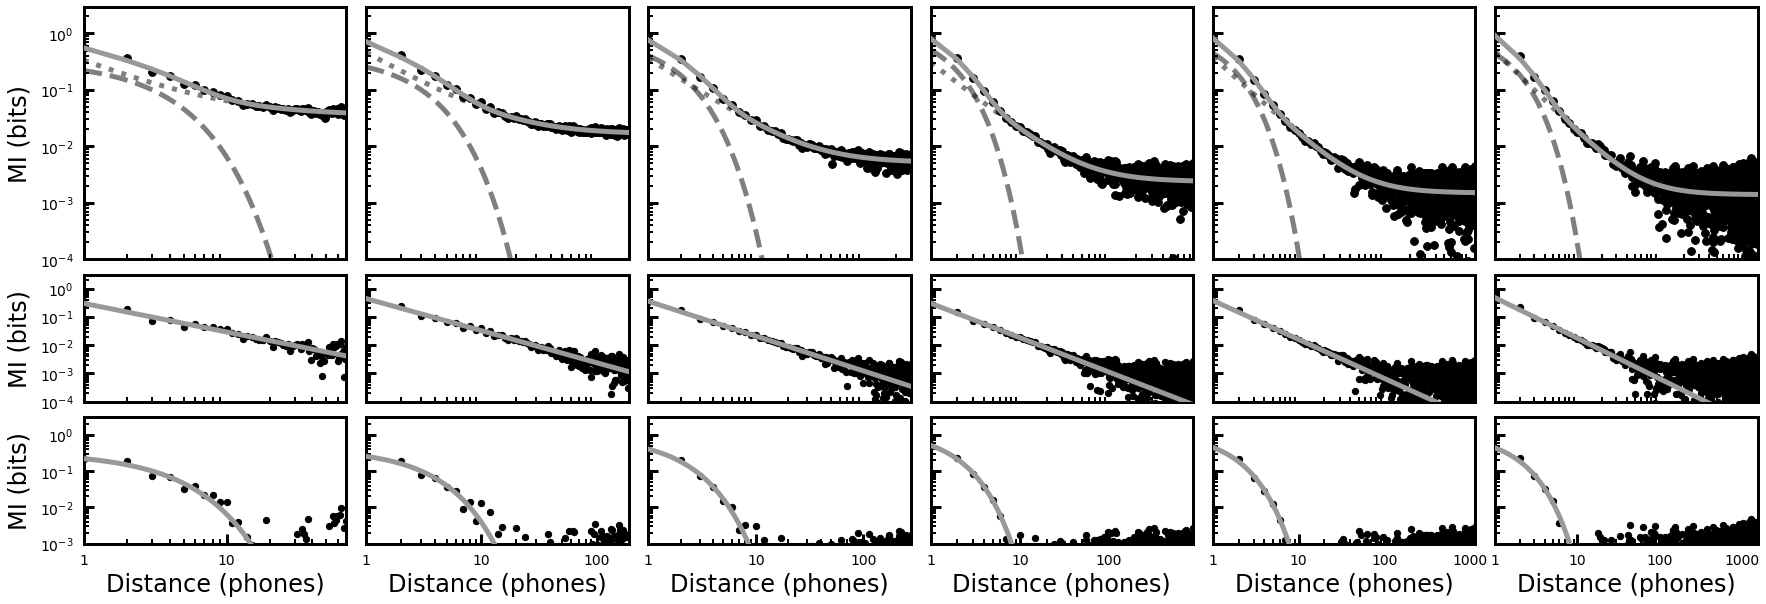

shuffled_within_words


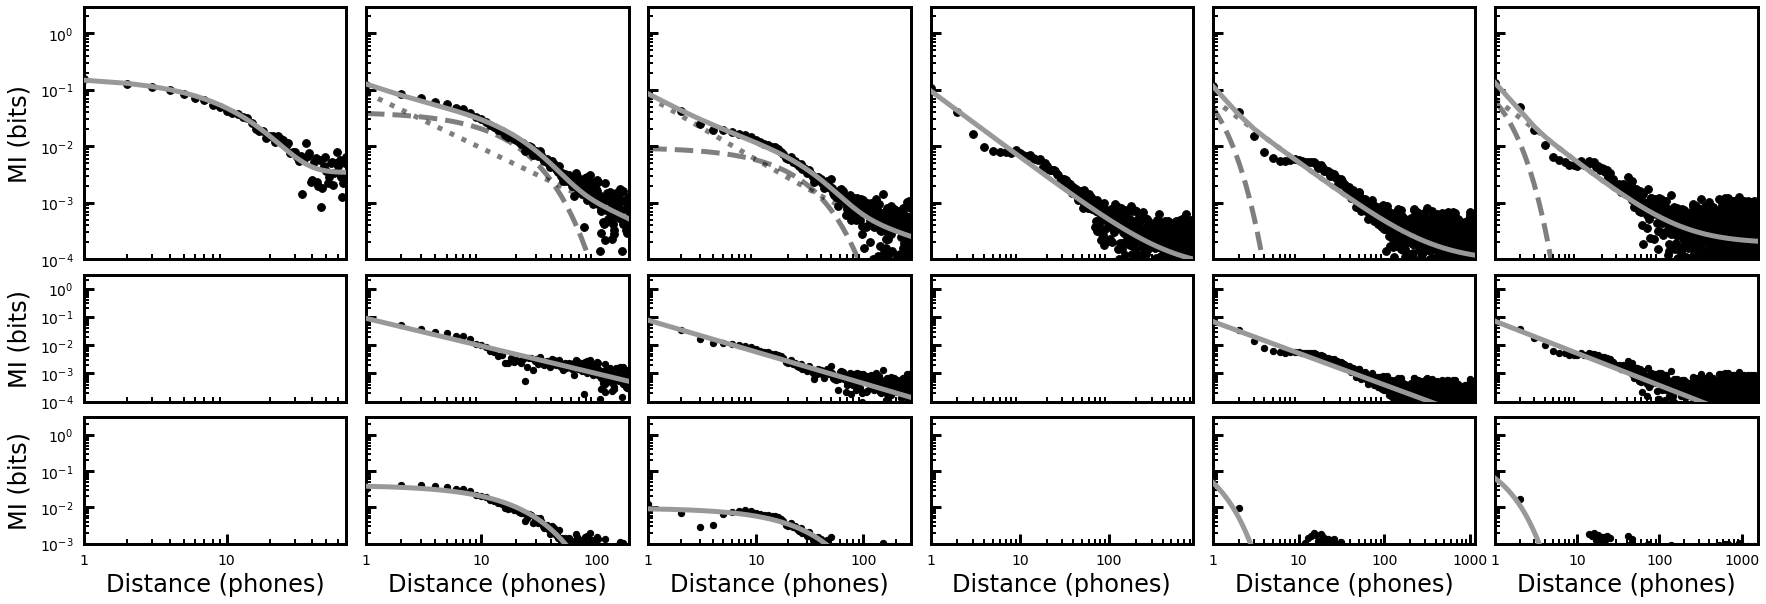

shuffled_between_words


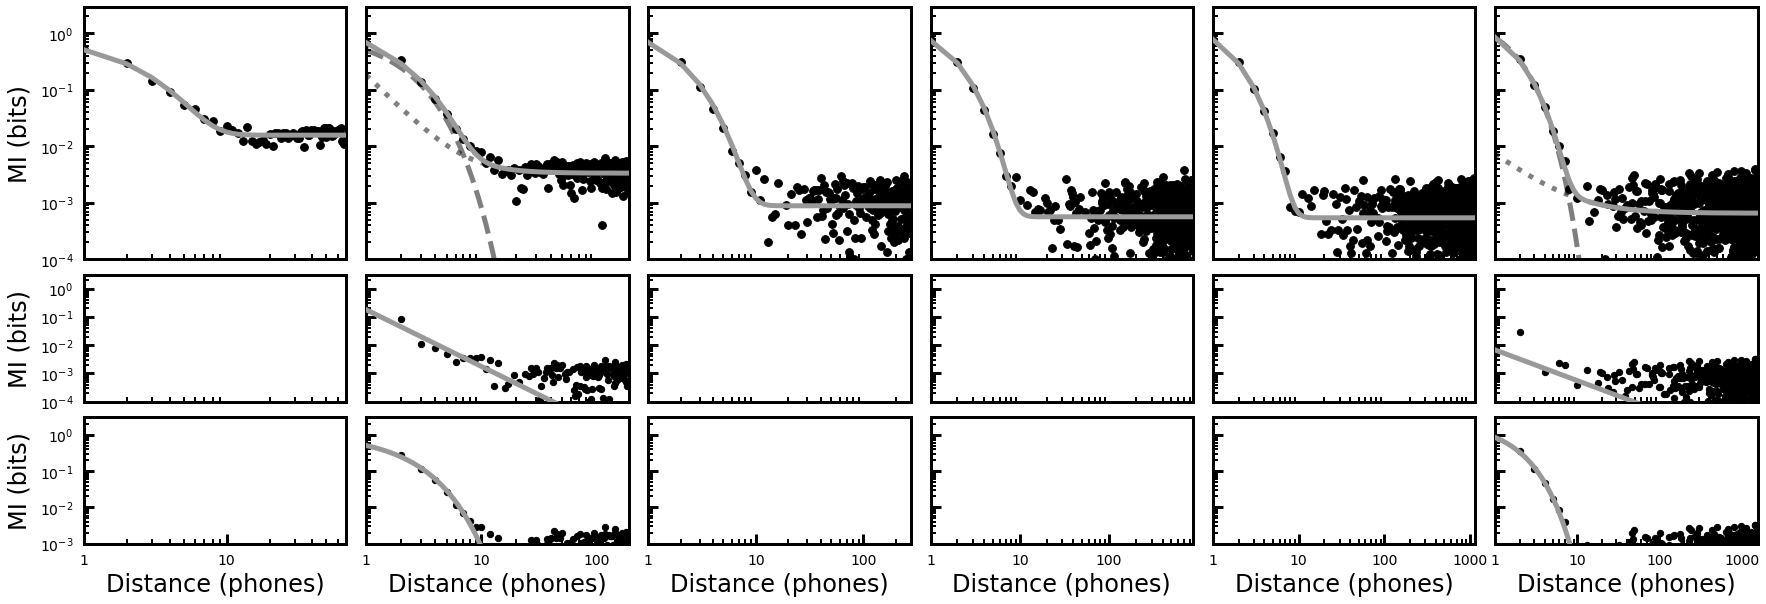

shuffled_within_utterance


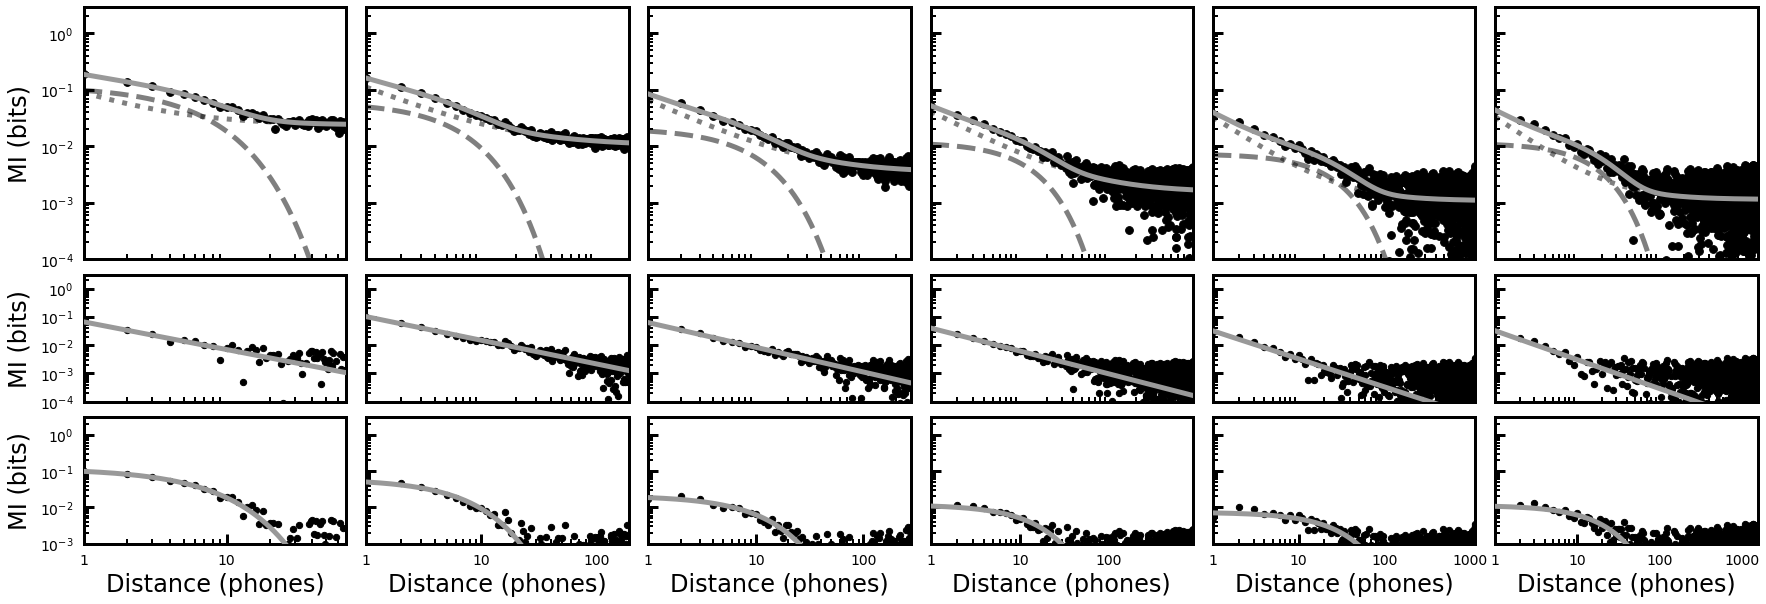

no_repeats


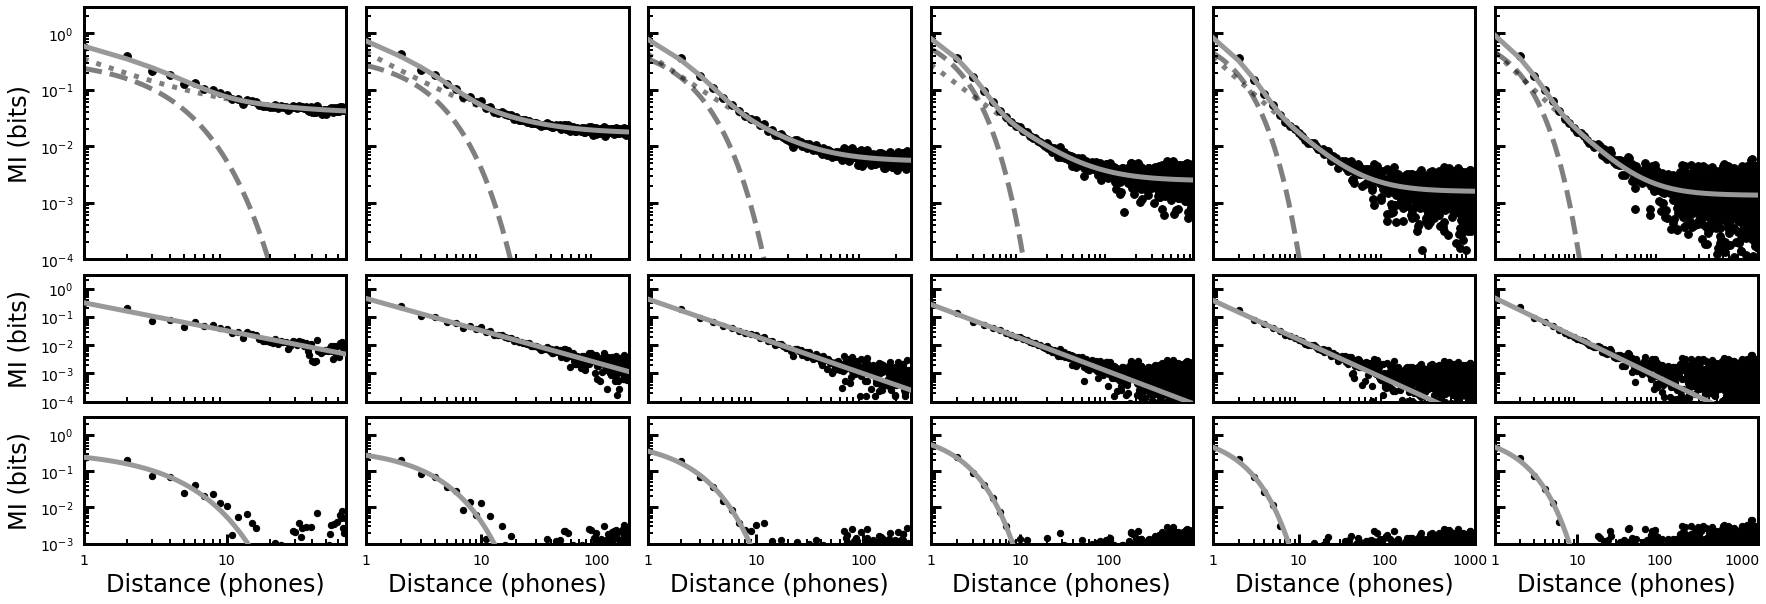

shuffled_between_utterance


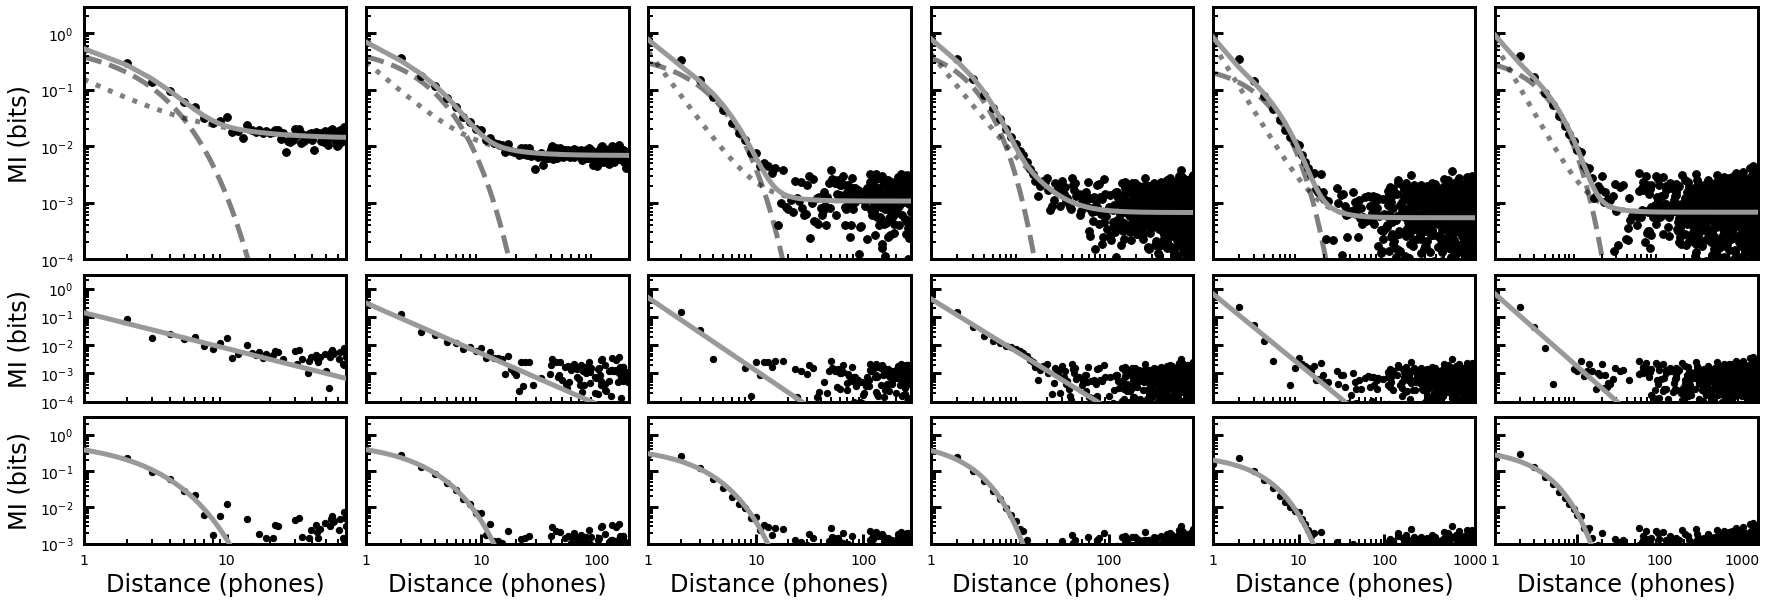

In [15]:
for cond in shuffling_conditions:
    print(cond)
    MI_DF_subset = MI_DF[MI_DF.shuffling == cond]
    len(MI_DF_subset)
    yoff=-.20
    ncols = 4
    zoom = 5
    hr = [1, 0.5, 0.5, 0.5]
    nrows = np.ceil(len(MI_DF_subset)/ncols).astype(int)
    fig = plt.figure(figsize=(len(MI_DF_subset)*zoom,np.sum(hr)*zoom)) 
    gs = gridspec.GridSpec(ncols=len(MI_DF_subset), nrows=4, height_ratios=hr) 

    for axi, (idx, row) in enumerate(MI_DF_subset.sort_values(by=['age_cohort_low']).iterrows()):
        color = 'k'#LCOL_DICT[row.language]
        ax0 = plt.subplot(gs[0,axi])
        ax = ax0
        sig = np.array(row.MI-row.shuff_MI)
        distances = row.distances
        sig = sig


        dist_mask = distances <= row.median_n_phones
        distances = distances[dist_mask]
        sig = sig[dist_mask]

        # get signal limits
        sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
        sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                        sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

        if axi==0: 
                ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
                ax.yaxis.set_label_coords(yoff,0.5)

        # model data
        #row.concat_results.params.intercept = 0
        distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
        
        if row.bestfitmodel == "pow_exp":
            y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)
            y_pow = mf.get_y(mf.powerlaw_decay, row.concat_results, distances_model)
            y_exp = mf.get_y(mf.exp_decay, row.concat_results, distances_model)
            y_pow_dat = mf.get_y(mf.powerlaw_decay, row.concat_results, distances)
            y_exp_dat = mf.get_y(mf.exp_decay, row.concat_results, distances)
        
        elif row.bestfitmodel == "pow":
            y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)
            y_pow = None
        
        elif row.bestfitmodel == "exp":
            y_model = mf.get_y(mf.exp_decay, row.exp_results, distances)
            y_pow = None
            
        # plot real data
        ax.scatter(distances, sig, alpha = 1, s=60, color=color)   
        if y_pow is not None:
            ax.plot(distances_model, y_pow, ls='dotted', color= 'k', lw=5, alpha=0.5)
            ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, ls='dashed', color= 'k', lw=5, alpha=0.5)

        # plot modelled data
        ax.plot(distances, y_model, alpha = 1, lw=5, color="#999999", zorder=10)
        
        ax1 = plt.subplot(gs[1,axi])
        ax2 = plt.subplot(gs[2,axi])

        if y_pow is not None:
            # plot powerlaw component
    
            ax = ax1
            ax.plot(distances_model, y_pow-row.concat_results.params['intercept'].value, alpha = 1, lw=5, color="#999999", zorder=10)
            ax.scatter(distances, sig-y_exp_dat, alpha = 1, s=40, color=color)   

            # plot exponential component
            ax = ax2
            ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, alpha = 1, lw=5, color="#999999", zorder=10)
            ax.scatter(distances, sig-y_pow_dat, alpha = 1, s=40, color=color)   


        ax = ax2
        ax.set_xlabel('Distance (phones)', labelpad=5, fontsize=24)
        #print(row.language, distances[peak_of_interest])

        for ax in [ax1, ax2]:
            if axi==0: 
                ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
                ax.yaxis.set_label_coords(yoff,0.5)

        for ax in [ax0,ax1,ax2]:
            ax.set_xlim([distances[0], distances[-1]])
            sig_lims[0] = np.log(10e-6)
            ax.set_ylim([1e-4, 3])
            ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
            ax.tick_params(which='major', length=10, width =3)
            ax.tick_params(which='minor', length=5, width =2)
            ax.set_xscale( "log" , basex=10)
            ax.set_yscale( "log" , basey=10)
            ax.set_xticks([])
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(3)
                ax.spines[axis].set_color('k')
        ax2.set_ylim([10e-4, 3])

        xtick_list = [1,10, 100, 1000, 10000]
        xtick_list = [i for i in xtick_list if i <= row.median_n_phones]

        ax2.set_xticks(xtick_list)
        ax2.set_xticklabels([str(i) for i in xtick_list])


        ac_high = np.min([row.age_cohort_high, 4])
        #ax0.set_title("{} to {} years old".format(row.age_cohort_low, ac_high), fontsize=24)

        if axi !=0:
            for ax in [ax0,ax1,ax2]:
                ax.yaxis.set_ticklabels([])

    gs.update(wspace=0.075, hspace=0.1)
    plt.show()
    #save_fig(FIGURE_DIR/'phonbank_mi')

full


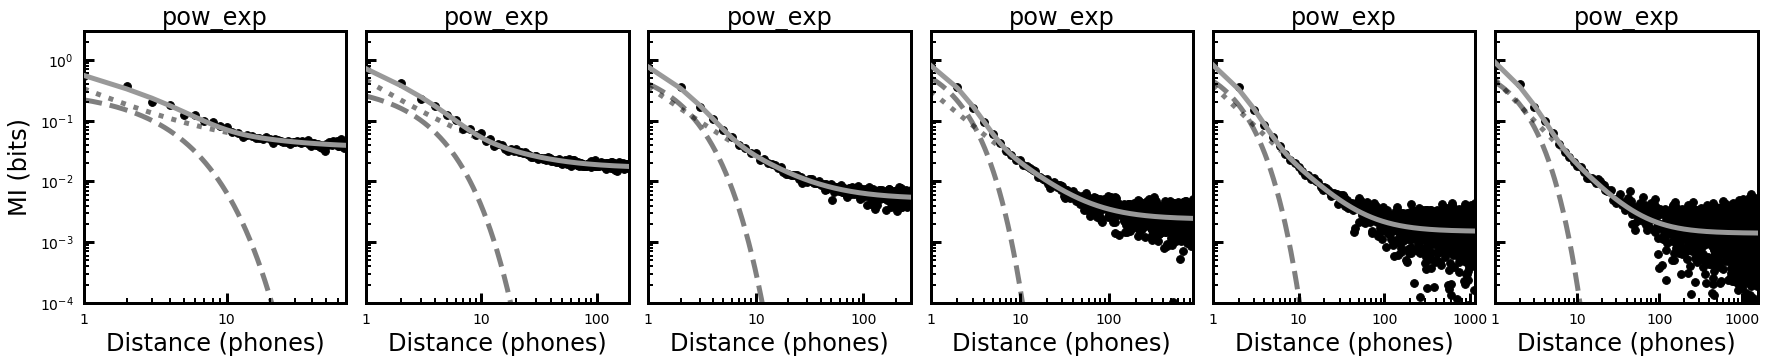

shuffled_within_words


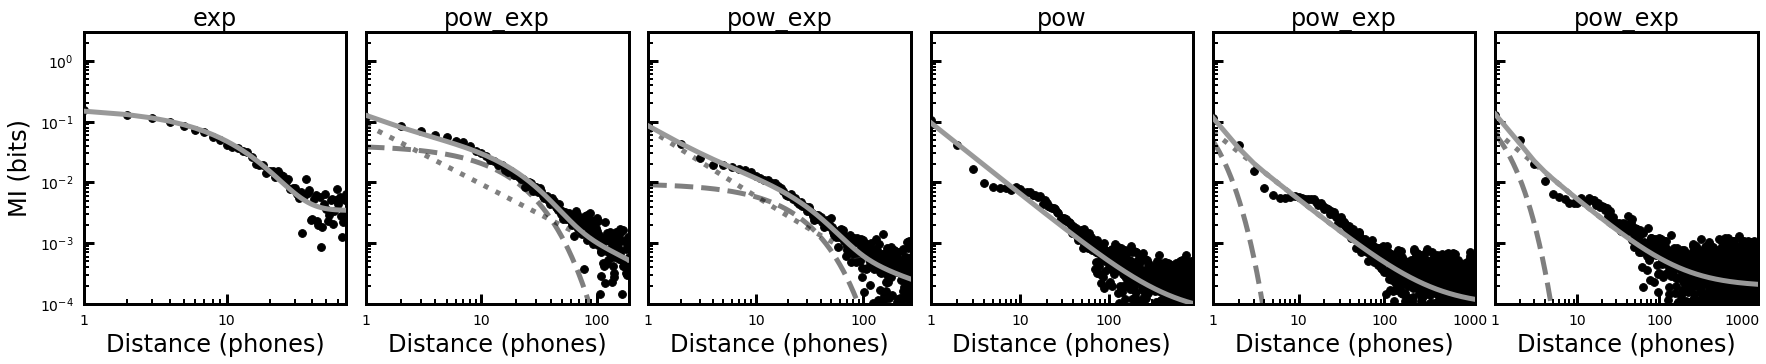

shuffled_between_words


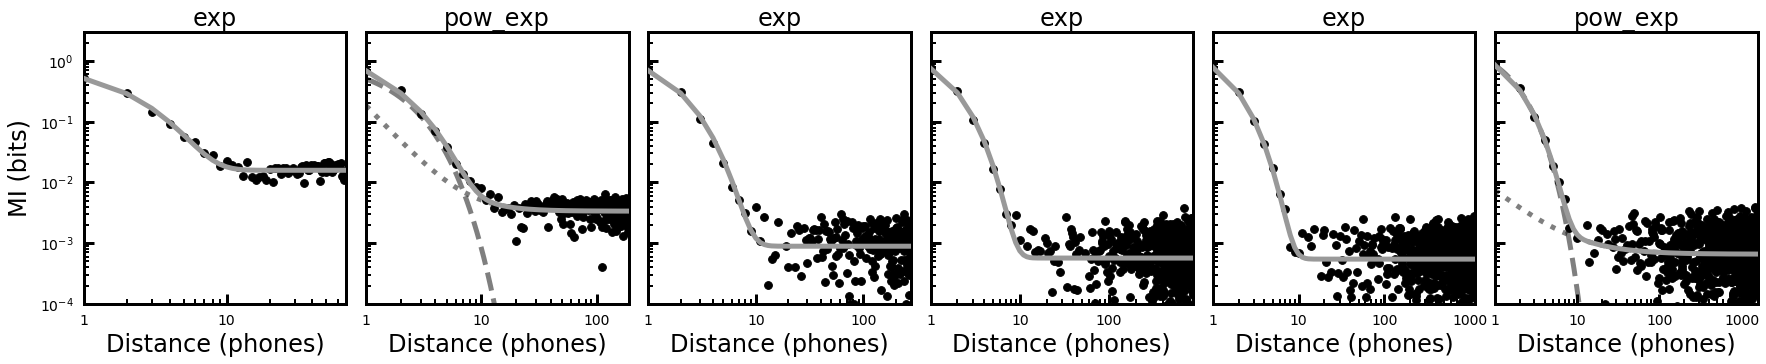

shuffled_within_utterance


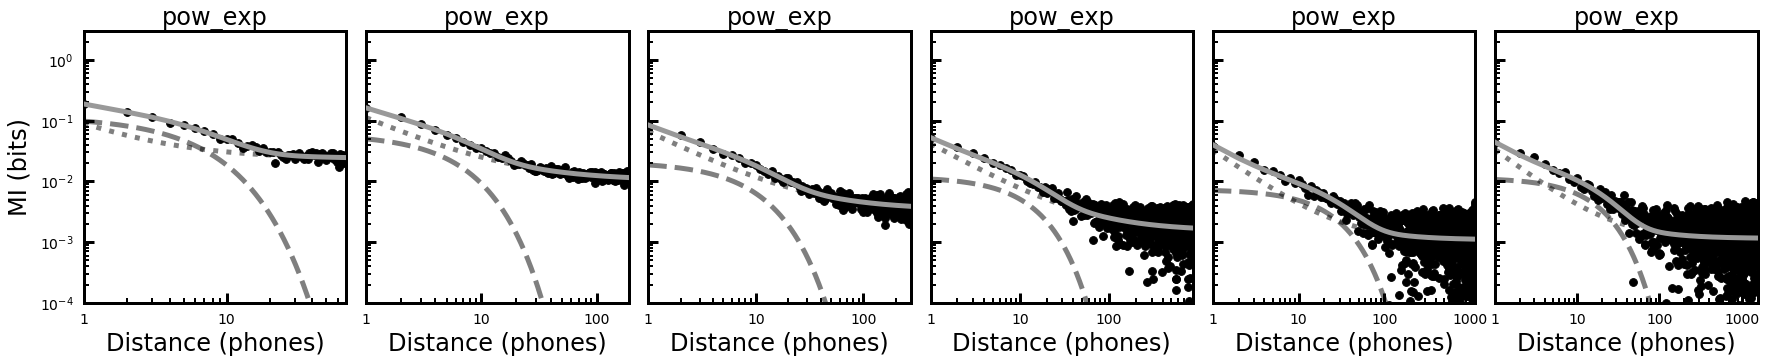

no_repeats


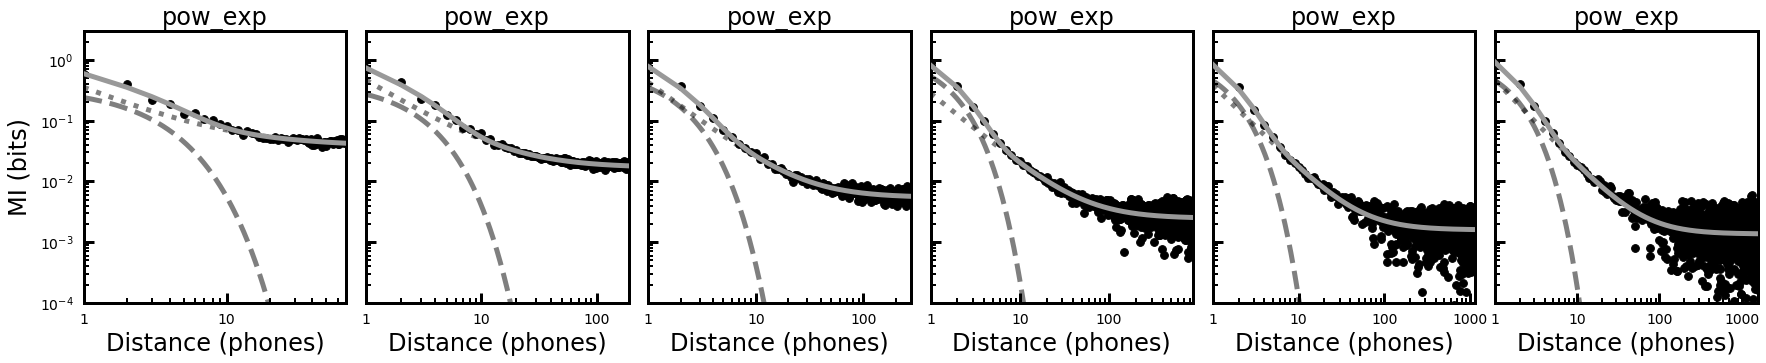

shuffled_between_utterance


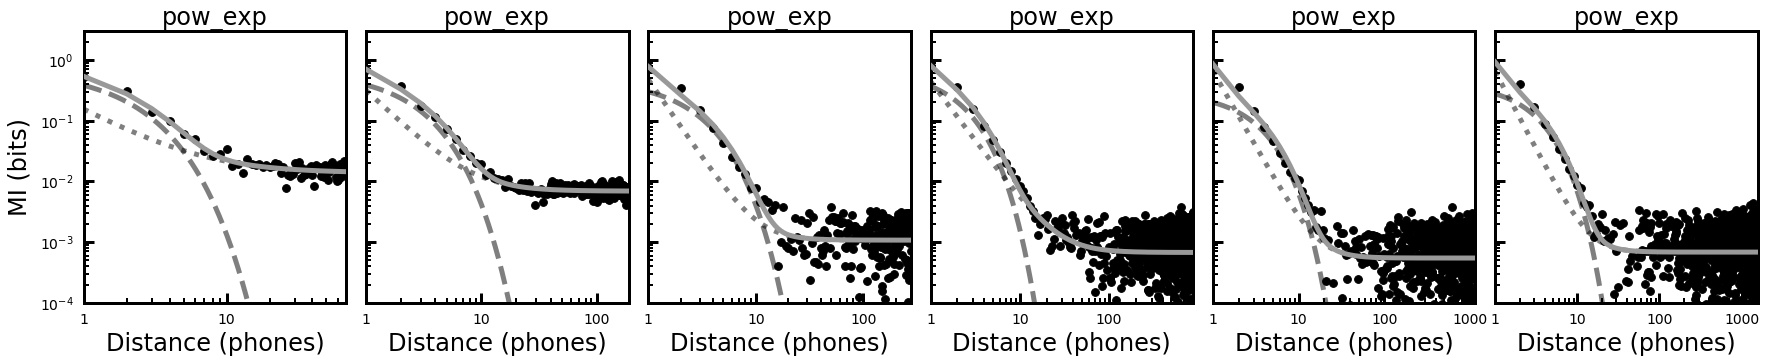

shuffled_within_transcript


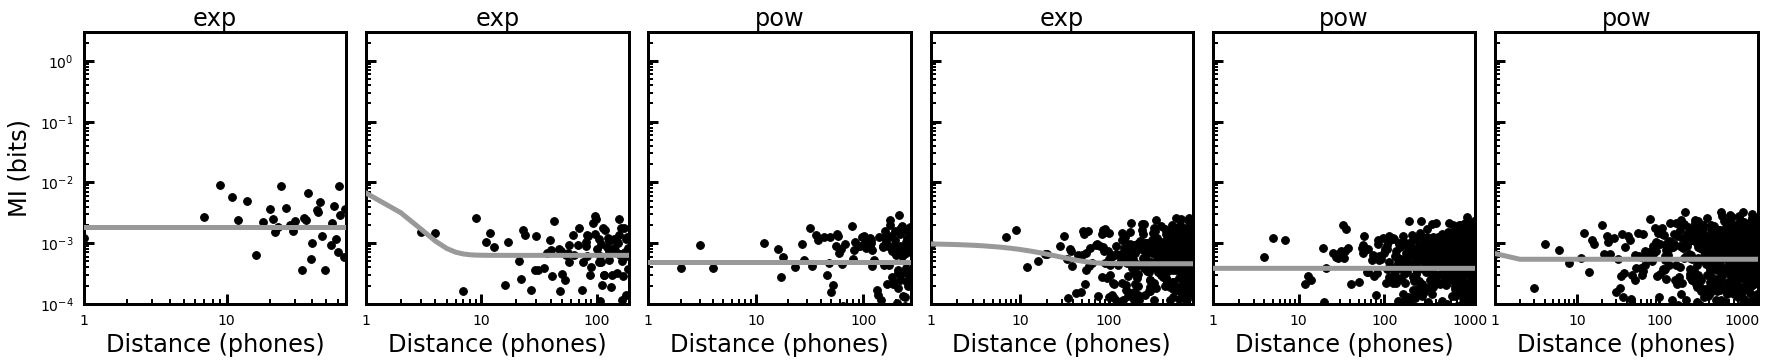

In [52]:
for cond in shuffling_conditions:
    print(cond)
    MI_DF_subset = MI_DF[MI_DF.shuffling == cond]
    len(MI_DF_subset)
    yoff=-.20
    ncols = 4
    zoom = 5
    hr = [1]
    nrows = np.ceil(len(MI_DF_subset)/ncols).astype(int)
    fig = plt.figure(figsize=(len(MI_DF_subset)*zoom,np.sum(hr)*zoom)) 
    gs = gridspec.GridSpec(ncols=len(MI_DF_subset), nrows=1, height_ratios=hr) 

    for axi, (idx, row) in enumerate(MI_DF_subset.sort_values(by=['age_cohort_low']).iterrows()):
        color = 'k'#LCOL_DICT[row.language]
        ax0 = plt.subplot(gs[0,axi])
        ax = ax0
        sig = np.array(row.MI-row.shuff_MI)
        distances = row.distances
        sig = sig


        dist_mask = distances <= row.median_n_phones
        distances = distances[dist_mask]
        sig = sig[dist_mask]

        # get signal limits
        sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
        sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                        sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

        if axi==0: 
                ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
                ax.yaxis.set_label_coords(yoff,0.5)

        # model data
        #row.concat_results.params.intercept = 0
        distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
        
        if row.bestfitmodel == "pow_exp":
            y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)
            y_pow = mf.get_y(mf.powerlaw_decay, row.concat_results, distances_model)
            y_exp = mf.get_y(mf.exp_decay, row.concat_results, distances_model)
            y_pow_dat = mf.get_y(mf.powerlaw_decay, row.concat_results, distances)
            y_exp_dat = mf.get_y(mf.exp_decay, row.concat_results, distances)
        
        elif row.bestfitmodel == "pow":
            y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)
            y_pow = None
        
        elif row.bestfitmodel == "exp":
            y_model = mf.get_y(mf.exp_decay, row.exp_results, distances)
            y_pow = None
            
        # plot real data
        ax.scatter(distances, sig, alpha = 1, s=60, color=color)   
        if y_pow is not None:
            ax.plot(distances_model, y_pow, ls='dotted', color= 'k', lw=5, alpha=0.5)
            ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, ls='dashed', color= 'k', lw=5, alpha=0.5)

        # plot modelled data
        ax.plot(distances, y_model, alpha = 1, lw=5, color="#999999", zorder=10)
        

        ax.set_xlabel('Distance (phones)', labelpad=5, fontsize=24)
        #print(row.language, distances[peak_of_interest])

        for ax in [ax0]:
            ax.set_xlim([distances[0], distances[-1]])
            sig_lims[0] = np.log(10e-6)
            ax.set_ylim([1e-4, 3])
            ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
            ax.tick_params(which='major', length=10, width =3)
            ax.tick_params(which='minor', length=5, width =2)
            ax.set_xscale( "log" , basex=10)
            ax.set_yscale( "log" , basey=10)
            ax.set_xticks([])
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(3)
                ax.spines[axis].set_color('k')

        xtick_list = [1,10, 100, 1000, 10000]
        xtick_list = [i for i in xtick_list if i <= row.median_n_phones]

        ax.set_xticks(xtick_list)
        ax.set_xticklabels([str(i) for i in xtick_list])


        ac_high = np.min([row.age_cohort_high, 4])
        ax0.set_title("{}".format(row.bestfitmodel), fontsize=24)

        if axi !=0:
            for ax in [ax0]:
                ax.yaxis.set_ticklabels([])

    gs.update(wspace=0.075, hspace=0.1)
    #save_fig(FIGURE_DIR/'phonbank_mi')
    
    ensure_dir(FIGURE_DIR/'shuffle'/'phonbank')
    save_fig(FIGURE_DIR/'shuffle'/'phonbank' / ('phonbank_mi_fit_'+cond))
    plt.show()


full


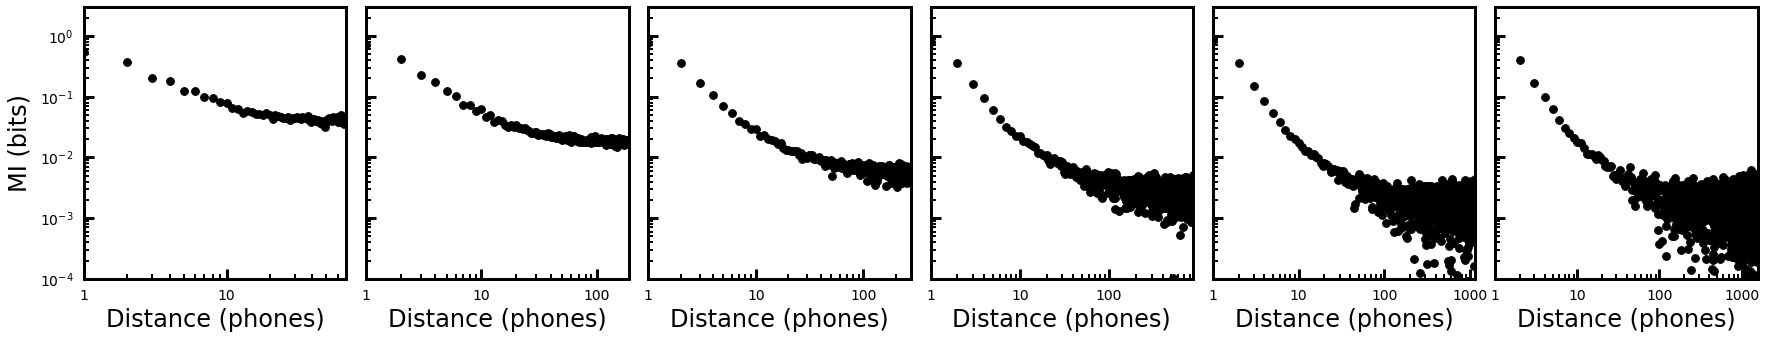

shuffled_within_words


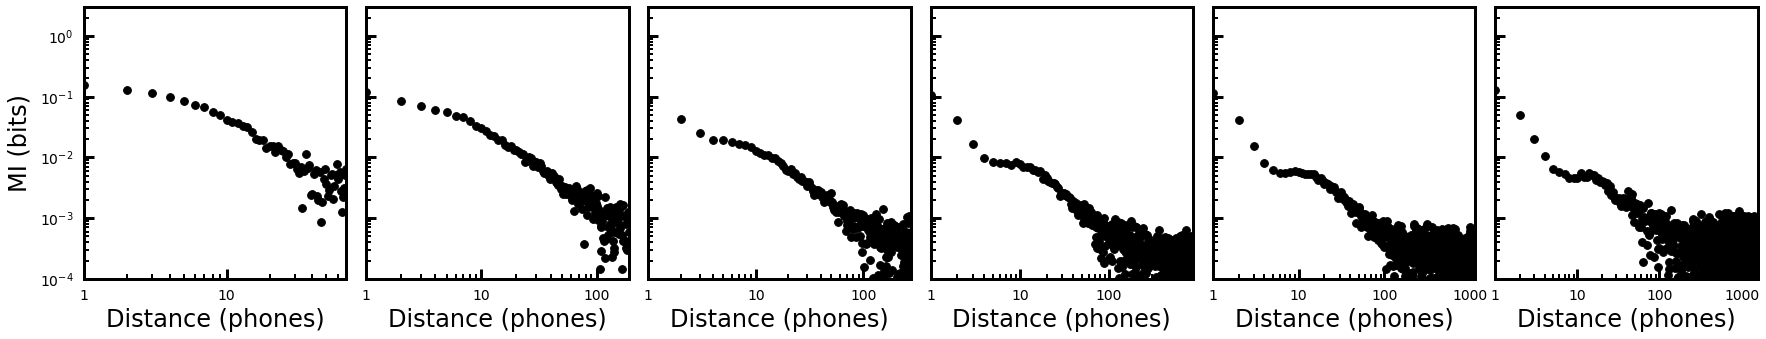

shuffled_between_words


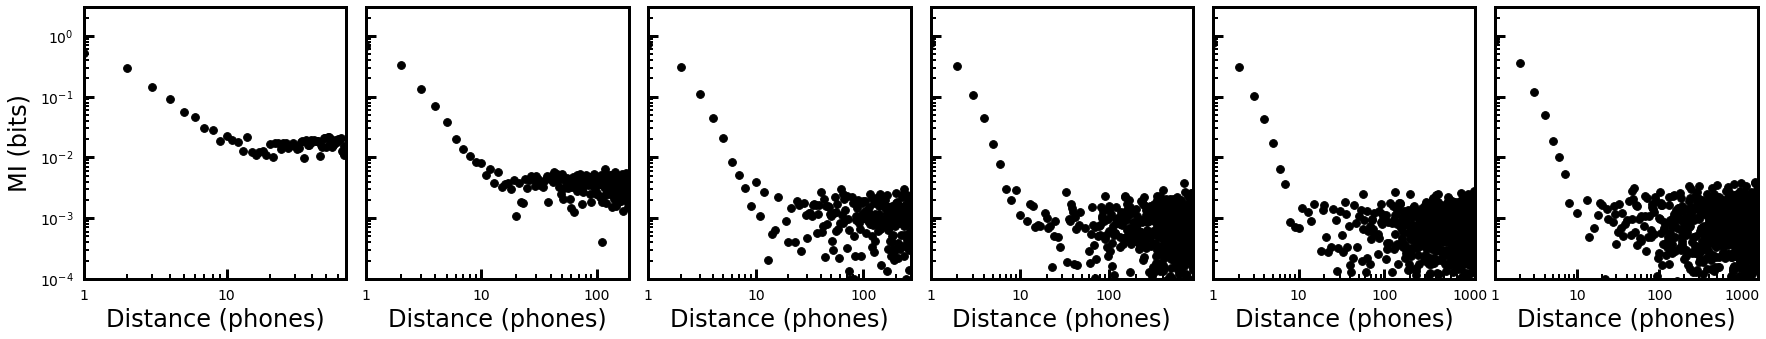

shuffled_within_utterance


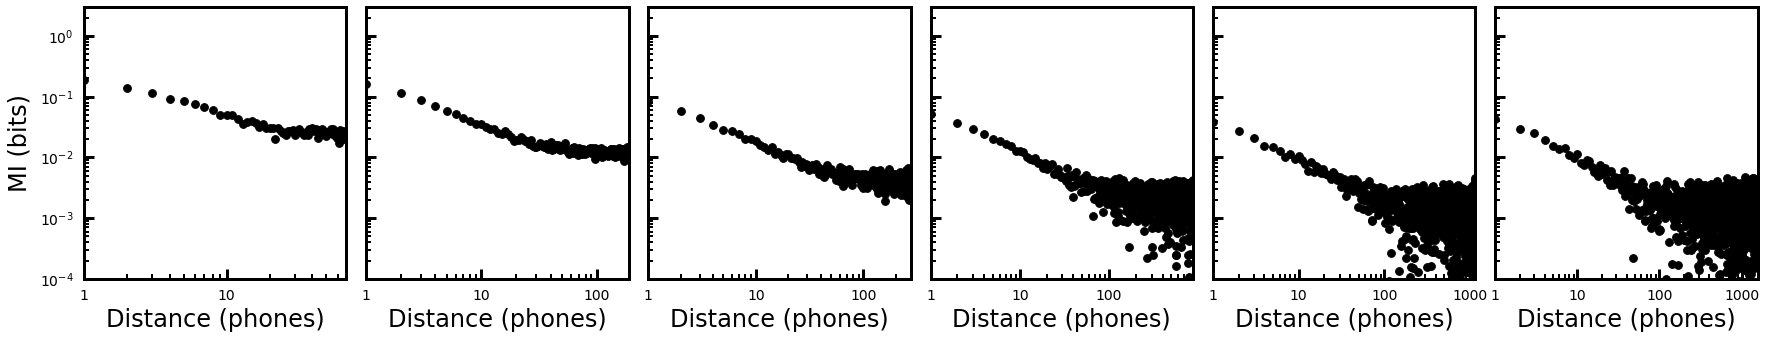

no_repeats


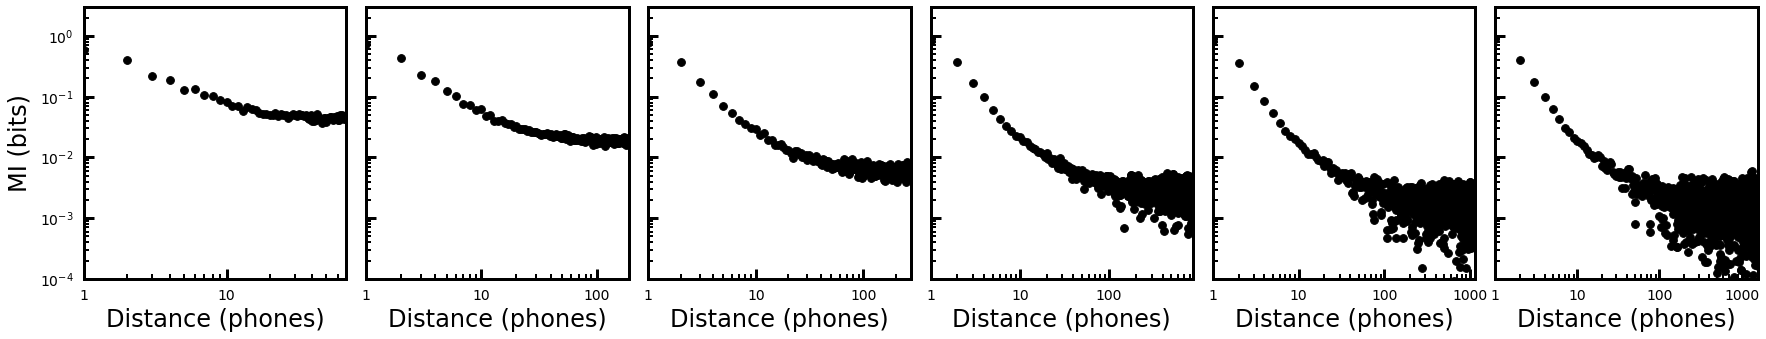

shuffled_between_utterance


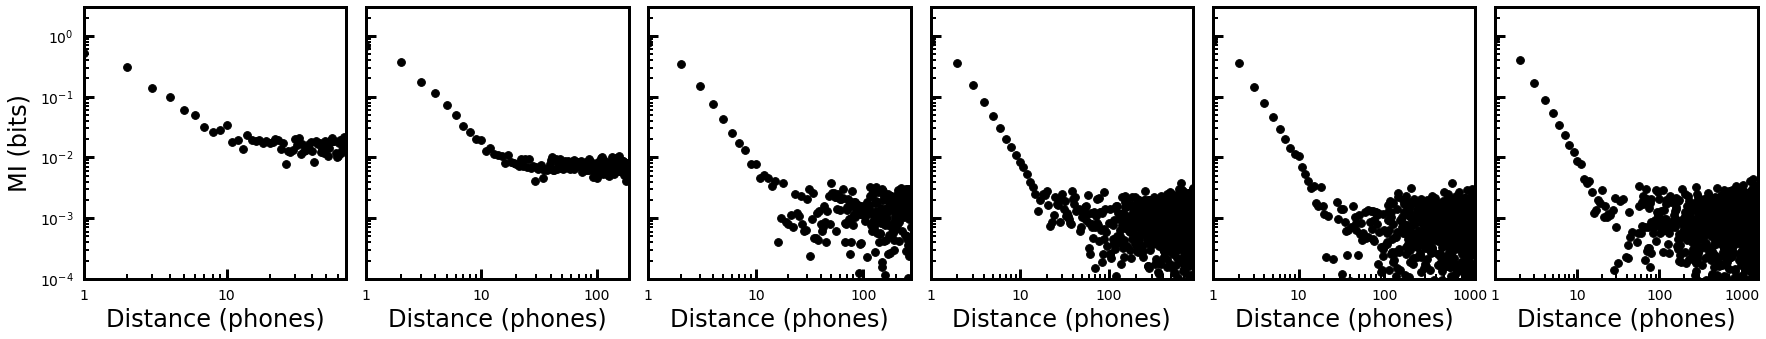

shuffled_within_transcript


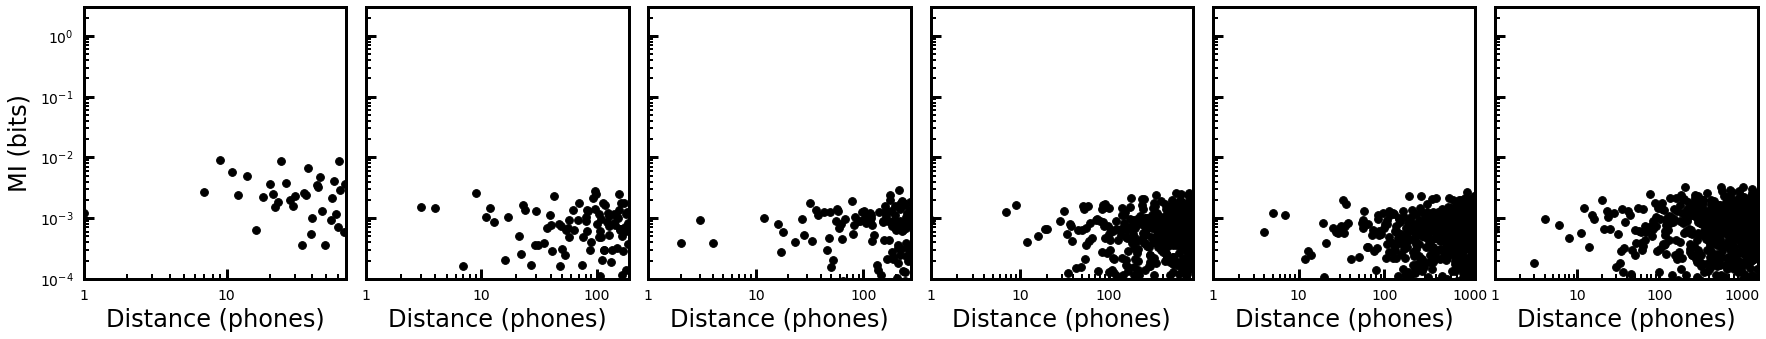

In [53]:
for cond in shuffling_conditions:
    print(cond)
    MI_DF_subset = MI_DF[MI_DF.shuffling == cond]
    len(MI_DF_subset)
    yoff=-.20
    ncols = 4
    zoom = 5
    hr = [1]
    nrows = np.ceil(len(MI_DF_subset)/ncols).astype(int)
    fig = plt.figure(figsize=(len(MI_DF_subset)*zoom,np.sum(hr)*zoom)) 
    gs = gridspec.GridSpec(ncols=len(MI_DF_subset), nrows=1, height_ratios=hr) 

    for axi, (idx, row) in enumerate(MI_DF_subset.sort_values(by=['age_cohort_low']).iterrows()):
        color = 'k'#LCOL_DICT[row.language]
        ax0 = plt.subplot(gs[0,axi])
        ax = ax0
        sig = np.array(row.MI-row.shuff_MI)
        distances = row.distances
        sig = sig


        dist_mask = distances <= row.median_n_phones
        distances = distances[dist_mask]
        sig = sig[dist_mask]

        # get signal limits
        sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
        sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                        sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

        if axi==0: 
                ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
                ax.yaxis.set_label_coords(yoff,0.5)

        # model data
        #row.concat_results.params.intercept = 0
        distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
        
            
        # plot real data
        ax.scatter(distances, sig, alpha = 1, s=60, color=color)   

        ax.set_xlabel('Distance (phones)', labelpad=5, fontsize=24)
        #print(row.language, distances[peak_of_interest])

        for ax in [ax0]:
            ax.set_xlim([distances[0], distances[-1]])
            sig_lims[0] = np.log(10e-6)
            ax.set_ylim([1e-4, 3])
            ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
            ax.tick_params(which='major', length=10, width =3)
            ax.tick_params(which='minor', length=5, width =2)
            ax.set_xscale( "log" , basex=10)
            ax.set_yscale( "log" , basey=10)
            ax.set_xticks([])
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(3)
                ax.spines[axis].set_color('k')

        xtick_list = [1,10, 100, 1000, 10000]
        xtick_list = [i for i in xtick_list if i <= row.median_n_phones]

        ax.set_xticks(xtick_list)
        ax.set_xticklabels([str(i) for i in xtick_list])

        ac_high = np.min([row.age_cohort_high, 4])

        if axi !=0:
            for ax in [ax0]:
                ax.yaxis.set_ticklabels([])
    
    gs.update(wspace=0.075, hspace=0.1)
    ensure_dir(FIGURE_DIR/'shuffle'/'phonbank')
    save_fig(FIGURE_DIR/'shuffle'/'phonbank' / ('phonbank_mi_nofit_'+cond))
    plt.show()


### prop model fit

In [17]:
from matplotlib import gridspec

In [18]:
import seaborn as sns

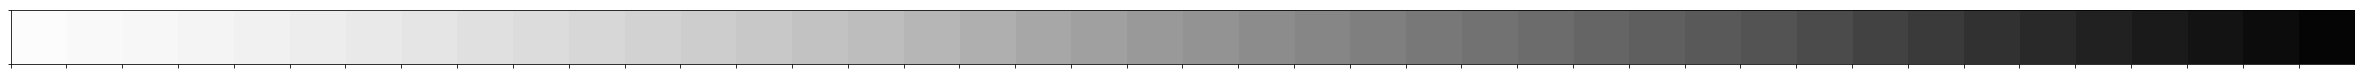

In [19]:
pal = sns.color_palette("Greys", n_colors=len(MI_DF))
sns.palplot(pal)

In [20]:
MI_DF_subset = MI_DF[MI_DF.shuffling == 'full']
len(MI_DF_subset)

6

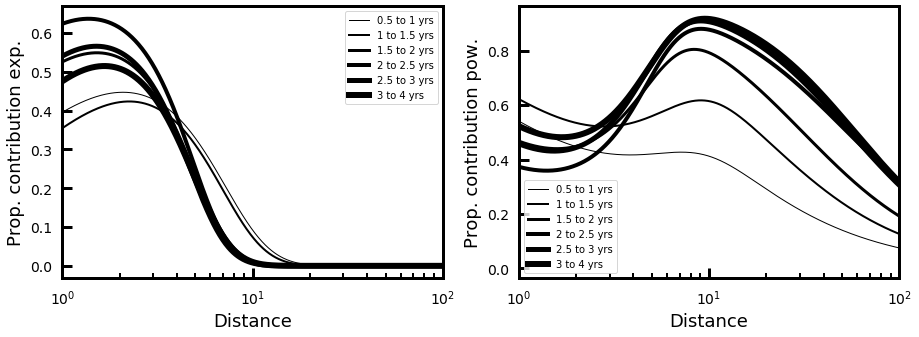

In [44]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
for axi, (idx, row) in enumerate(MI_DF_subset.sort_values(by=['age_cohort_low']).iterrows()):
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
    y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances_model)
    y_pow = mf.get_y(mf.powerlaw_decay, row.concat_results, distances_model) - row.concat_results.params['intercept'].value
    y_exp = mf.get_y(mf.exp_decay, row.concat_results, distances_model) - row.concat_results.params['intercept'].value
    ac_high = np.min([row.age_cohort_high, 4])
    lab = "{} to {} yrs".format(row.age_cohort_low, ac_high)

    axs[0].plot(distances_model, y_exp/y_model, color = 'k', ls='solid', lw = axi+1, label = lab)
    axs[1].plot(distances_model, y_pow/y_model, color = 'k', ls='solid', lw = axi+1, label = lab)
    
axs[0].set_ylabel('Prop. contribution exp.', labelpad=5, fontsize=18)
axs[1].set_ylabel('Prop. contribution pow.', labelpad=5, fontsize=18)
    
for ax in axs:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color('k')
    ax.set_xticks([1,10,100])
    ax.set_xticklabels(['1','10','100'])
    ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
    ax.tick_params(which='major', length=10, width =3)
    ax.tick_params(which='minor', length=5, width =2)
    ax.set_xlim([1,100])
    ax.set_xscale( "log" , basex=10)
    ax.legend()
    ax.set_xlabel('Distance', labelpad=5, fontsize=18)

save_fig(FIGURE_DIR/'phonbank_model_contribution')

In [22]:
MI_DF_subset = MI_DF[MI_DF.shuffling == 'shuffled_between_words']
len(MI_DF_subset)

6

### results table

In [23]:
labels = ['6-12 months', '12-18 months', '18-24 months', '24-30 months', '30-36 months', '3+ years']

### Calculate R2

In [24]:
MI_DF_subset = MI_DF[MI_DF.shuffling == 'full']
len(MI_DF_subset)

6

In [25]:
R2 = MI_DF_subset[['R2_exp', 'R2_concat', 'R2_power']]
R2.columns = ['exp', 'combined', 'power-law']
R2.index = labels
R2 = R2.T
R2

,6-12 months,12-18 months,18-24 months,24-30 months,30-36 months,3+ years
exp,0.803401,0.878042,0.928345,0.967224,0.982606,0.989429
combined,0.841454,0.919141,0.970816,0.995300,0.998267,0.996240
power-law,0.840546,0.917873,0.968820,0.993910,0.996012,0.992054


### AICc

In [26]:
AICcs = MI_DF_subset[['AICc_exp', 'AICc_concat', 'AICc_power']]
AICcs.columns = ['exp', 'combined.', 'power-law']
AICcs.index = labels
AICcs = AICcs.T
AICcs

,6-12 months,12-18 months,18-24 months,24-30 months,30-36 months,3+ years
exp,-5687.125636,-4842.293603,-4240.434571,-1371.612713,-1091.127775,-417.620810
combined.,-5998.032033,-5302.247642,-5025.959503,-1903.498491,-1522.767091,-484.369052
power-law,-5993.698165,-5288.715808,-4971.833866,-1836.156531,-1369.500558,-437.314917


#### $\Delta$AIC

In [27]:
delta_AICcs = AICcs.T - np.repeat(np.min(AICcs.T.values, axis=1),3).reshape(len(labels),3)
delta_AICcs = delta_AICcs.T
delta_AICcs

,6-12 months,12-18 months,18-24 months,24-30 months,30-36 months,3+ years
exp,310.906397,459.954039,785.524932,531.885778,431.639317,66.748242
combined.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
power-law,4.333868,13.531834,54.125637,67.341960,153.266533,47.054135


### relative likelihood

In [28]:
relative_likelihoods = mf.relative_likelihood(delta_AICcs)
relative_likelihoods

,6-12 months,12-18 months,18-24 months,24-30 months,30-36 months,3+ years
exp,3.072796e-68,1.325102e-100,2.663351e-171,3.180320e-116,1.865148e-94,3.204819e-15
combined.,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
power-law,1.145282e-01,1.152390e-03,1.765092e-12,2.381657e-15,5.231126e-34,6.057934e-11


### relative probability of models

In [29]:
prob_models = mf.Prob_model_Given_data_and_models(relative_likelihoods)
prob_models

,6-12 months,12-18 months,18-24 months,24-30 months,30-36 months,3+ years
exp,2.757037e-68,1.323577e-100,2.663351e-171,3.180320e-116,1.865148e-94,3.204819e-15
combined.,8.972406e-01,9.988489e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
power-law,1.027594e-01,1.151064e-03,1.765092e-12,2.381657e-15,5.231126e-34,6.057934e-11


#### Join tables

In [30]:
AICcs['superlabel'] = 'AICc'
relative_likelihoods['superlabel'] = 'Relative likelihood'
R2['superlabel'] = '$r^2$'
prob_models['superlabel'] = 'Relative probability'

In [31]:
results_table = pd.concat([
    AICcs,
    R2,
    relative_likelihoods,
    prob_models
]).round(3).replace(0, '<0.001').replace(1, '>0.999')
results_table[''] = results_table.index
results_table.set_index(['superlabel', ''], inplace=True)
results_table

6-12 months 12-18 months 18-24 months  \
superlabel                                                             
AICc                 exp          -5687.13     -4842.29     -4240.44   
                     combined.    -5998.03     -5302.25     -5025.96   
                     power-law     -5993.7     -5288.72     -4971.83   
$r^2$                exp             0.803        0.878        0.928   
                     combined        0.841        0.919        0.971   
                     power-law       0.841        0.918        0.969   
Relative likelihood  exp            <0.001       <0.001       <0.001   
                     combined.      >0.999       >0.999       >0.999   
                     power-law       0.115        0.001       <0.001   
Relative probability exp            <0.001       <0.001       <0.001   
                     combined.       0.897        0.999       >0.999   
                     power-law       0.103        0.001       <0.001   

                               24-30 months 30-36 months 3+ years  
superlabel                                                         
AICc                 exp           -1371.61     -1091.13 -417.621  
                     combined.      -1903.5     -1522.77 -484.369  
                     power-law     -1836.16      -1369.5 -437.315  
$r^2$                exp              0.967        0.983    0.989  
                     combined         0.995        0.998    0.996  
                     power-law        0.994        0.996    0.992  
Relative likelihood  exp             <0.001       <0.001   <0.001  
                     combined.       >0.999       >0.999   >0.999  
                     power-law       <0.001       <0.001   <0.001  
Relative probability exp             <0.001       <0.001   <0.001  
                     combined.       >0.999       >0.999   >0.999  
                     power-law       <0.001       <0.001   <0.001

In [32]:
results_string = results_table.to_latex(bold_rows=True, escape=False)\
      .replace('>', '$>$')\
      .replace('<', '$<$')\
      .replace('superlabel', '')\
     .replace('\n\\textbf', '\n\midrule\n\\textbf')
print(results_string)

\begin{tabular}{llllllll}
\toprule
                     &           & 6-12 months & 12-18 months & 18-24 months & 24-30 months & 30-36 months & 3+ years \\
\midrule
\textbf{} & {} &             &              &              &              &              &          \\
\midrule
\midrule
\textbf{AICc} & \textbf{exp} &    -5687.13 &     -4842.29 &     -4240.44 &     -1371.61 &     -1091.13 & -417.621 \\
                     & \textbf{combined.} &    -5998.03 &     -5302.25 &     -5025.96 &      -1903.5 &     -1522.77 & -484.369 \\
                     & \textbf{power-law} &     -5993.7 &     -5288.72 &     -4971.83 &     -1836.16 &      -1369.5 & -437.315 \\
\midrule
\textbf{$r^2$} & \textbf{exp} &       0.803 &        0.878 &        0.928 &        0.967 &        0.983 &    0.989 \\
                     & \textbf{combined} &       0.841 &        0.919 &        0.971 &        0.995 &        0.998 &    0.996 \\
                     & \textbf{power-law} &       0.841 &        0.918 &        0